# Tutorial on fitting single dataset using Inverse Solver

In [1]:
import numpy as np
import ticktack
import jax.numpy as jnp
from jax import jit
from ticktack import fitting
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('seaborn-colorblind')

In [2]:
sf = fitting.SingleFitter('Guttler15', 'Guttler15')
sf.load_data('miyake12.csv')
sf.compile_production_model("inverse_solver")

INFO[2022-03-15 20:13:54,362]: Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: 
INFO[2022-03-15 20:13:54,363]: Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-03-15 20:13:54,364]: Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.
WARNING[2022-03-15 20:13:54,364]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
chain = sf.MC_reconstruct(iters=1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.69it/s]


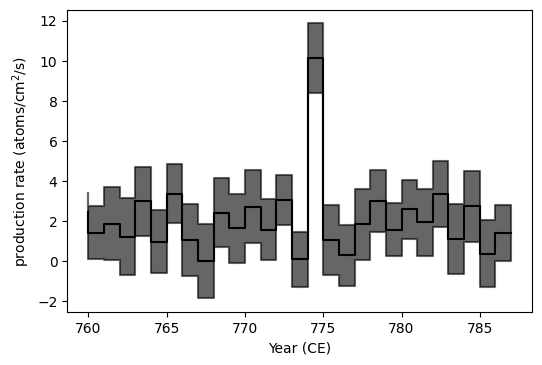

In [36]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
mean = np.mean(chain, axis=0)
std = np.std(chain, axis=0)
ax.errorbar(sf.time_data, mean, color='k', drawstyle="steps")
ax.fill_between(sf.time_data, mean - std, mean + std,
                step='pre', alpha=0.6, facecolor=(0, 0, 0, .1),
                edgecolor=(0, 0, 0, 0.8), lw=1.5)
ax.set_xlabel("Year (CE)")
ax.set_ylabel("production rate (atoms/cm$^2$/s)");

In [13]:
def d14c(params):
    event = sf.run_event(y0=sf.steady_state_y0, params=(params,))
    binned_d14c = sf.cbm.bin_data(event[:, sf.box_idx], sf.oversample, sf.annual, growth=sf.growth)
    return (binned_d14c - sf.steady_state_y0[sf.box_idx]) / sf.steady_state_y0[sf.box_idx] * 1000 + sf.d14c_data[0]

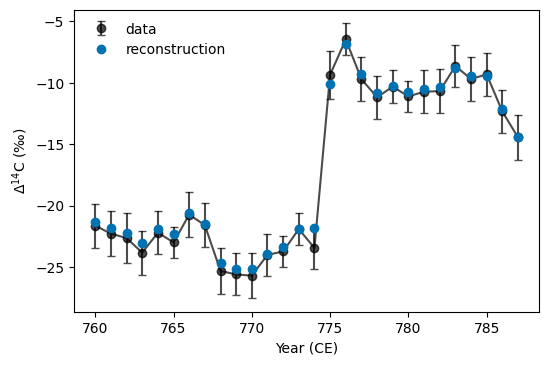

In [37]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']
ax.errorbar(sf.time_data, sf.d14c_data, sf.d14c_data_error, fmt='o', capsize=3, color="k", alpha=0.7, label="data")
ax.plot(sf.time_data, sf.d14c_data, color="k", alpha=0.7)
ax.errorbar(sf.time_data, d14c(mean), fmt='o', color=colors[0], label="reconstruction")
ax.legend(frameon=False)
ax.set_ylabel("$\Delta^{14}$C (‰)")
ax.set_xlabel("Year (CE)");